In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
# download, decompress the data
#!mkdir -p train_data
#!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip -O train_data/balloon_dataset.zip
#!unzip -q train_data/balloon_dataset.zip -d train_data/


In [4]:
from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("train_data/balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

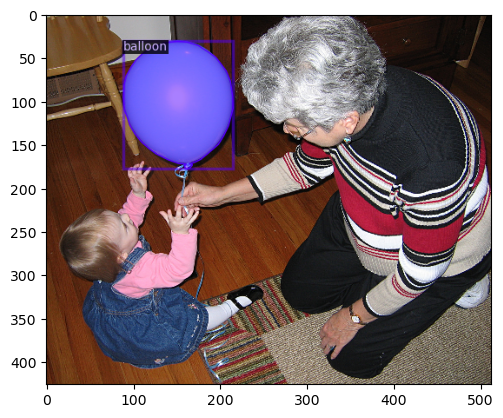

In [5]:
import matplotlib.pyplot as plt
dataset_dicts = get_balloon_dicts("train_data/balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())

In [6]:
#!pip install wandb

In [7]:
#!wandb login --relogin --host=https://prod.wandb.int.bayer.com

In [8]:
import wandb
import detectron2
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, hooks, launch
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import os
import pandas as pd

In [9]:
wandb.init(project="Instance-Segmentation-Detectron2")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aismail. Use `wandb login --relogin` to force relogin


In [10]:
class WandbTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(
            dataset_name=dataset_name,
            output_dir=output_folder,
            distributed=False  
        )

    def build_hooks(self):
        hooks_list = super().build_hooks()
        evaluator = self.build_evaluator(self.cfg, "balloon_val")      
        hooks_list.insert(-1, WandbHook(evaluator))
        return hooks_list

class WandbHook(hooks.HookBase):
    def __init__(self, evaluator,window_size=20):
        self.evaluator = evaluator
        self.window_size = window_size

    def after_step(self):
        
        storage = self.trainer.storage
        metrics = {}
        desired_metrics=['total_loss','loss_cls','loss_box_reg','loss_mask','loss_rpn_cls','loss_rpn_loc','lr']

        for key in storage._history:
            if key not in desired_metrics:
                continue
            history_values = storage.history(key).values()
            if history_values:
                # Unpack the first element of the tuples to get the values
                vals = [i for i, j in history_values]
                series = pd.Series(vals)
                rolling_mean = series.rolling(window=self.window_size, min_periods=1).mean()
                metrics[f"train/{key}"] = rolling_mean.iloc[-1]
        wandb.log(metrics)
        #step=self.trainer.iter
        eval_period = self.trainer.cfg.TEST.EVAL_PERIOD
        if eval_period > 0 and self.trainer.iter % eval_period == 0 and self.trainer.iter != 0:
            val_loader = build_detection_test_loader(self.trainer.cfg, "balloon_val")
            val_results = inference_on_dataset(self.trainer.model, val_loader, self.evaluator)
            wandb.log({
                "mAP Box": val_results['bbox']['AP'],  # Assuming mAP is stored in 'bbox/AP'
                "mAP Segmentation": val_results['segm']['AP'],  # mAP from COCO Evaluator
            })

In [11]:
model_arch="COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml"
wandb.run.name = model_arch.split("/")[-1].replace(".yaml","")+"_lr_3e-3"
wandb.run.name


'mask_rcnn_R_101_C4_3x_lr_3e-3'

In [12]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model_arch))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_arch) 
cfg.SOLVER.IMS_PER_BATCH = 4  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.003  # pick a good LR
cfg.SOLVER.MAX_ITER = 500  
cfg.TEST.EVAL_PERIOD = 50 
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [13]:
# Step 2: Initialize WandB config with Detectron2 config
wandb.config.update(cfg)

In [14]:
trainer = WandbTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[08/25 07:34:12 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[08/25 07:34:13 d2.data.build]: Removed 0 images with no usable annotations. 61 images left.
[08/25 07:34:13 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  balloon   | 255          |
|            |              |
[08/25 07:34:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[08/25 07:34:13 d2.data.build]: Using training sampler TrainingSampler
[08/25 07:34:13 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 07:34:13 d2.data.common]: Serializing 61 elements to byte tensors and concatenating them all ...
[08/25 07:34:13 d2.data.common]: Serialized dataset takes 0.17 MiB
[08/25 07:34:13 d2.data.build]: Making batched data loader with batch_size=4
[08/25 07:34:13 d2.evaluation.coco_evaluation]: Fast COC

model_final_a2914c.pkl: 220MB [00:00, 276MB/s]                            
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (2, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (4, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to i

[08/25 07:34:14 d2.engine.train_loop]: Starting training from iteration 0


/home/ec2-user/.local/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


[08/25 07:34:26 d2.utils.events]:  eta: 0:04:14  iter: 19  total_loss: 2.11  loss_cls: 0.6718  loss_box_reg: 0.7491  loss_mask: 0.6472  loss_rpn_cls: 0.1261  loss_rpn_loc: 0.02246    time: 0.5611  last_time: 0.6840  data_time: 0.0825  last_data_time: 0.1897   lr: 0.00011689  max_mem: 5724M
[08/25 07:34:37 d2.utils.events]:  eta: 0:03:58  iter: 39  total_loss: 1.413  loss_cls: 0.2833  loss_box_reg: 0.7183  loss_mask: 0.2969  loss_rpn_cls: 0.1068  loss_rpn_loc: 0.02008    time: 0.5447  last_time: 0.6395  data_time: 0.0430  last_data_time: 0.1415   lr: 0.00023677  max_mem: 5724M
[08/25 07:34:44 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  balloon   | 50           |
|            |              |
[08/25 07:34:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 07:34:44 d2.data.common]: Ser

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.820
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.902
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.884
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.111
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.636
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.961
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.252
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.790
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.858
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

[08/25 07:36:27 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[08/25 07:36:27 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[08/25 07:36:27 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.801
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.935
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.902
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.927
 Average Rec

[08/25 07:37:15 d2.utils.events]:  eta: 0:01:55  iter: 279  total_loss: 0.2217  loss_cls: 0.03121  loss_box_reg: 0.1173  loss_mask: 0.05101  loss_rpn_cls: 0.003852  loss_rpn_loc: 0.01433    time: 0.5499  last_time: 0.5031  data_time: 0.0508  last_data_time: 0.0088   lr: 0.0016753  max_mem: 5859M
[08/25 07:37:26 d2.utils.events]:  eta: 0:01:44  iter: 299  total_loss: 0.1902  loss_cls: 0.02685  loss_box_reg: 0.1019  loss_mask: 0.04597  loss_rpn_cls: 0.002835  loss_rpn_loc: 0.01066    time: 0.5488  last_time: 0.6167  data_time: 0.0439  last_data_time: 0.1422   lr: 0.0017952  max_mem: 5859M
[08/25 07:37:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/25 07:37:26 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/25 07:37:26 d2.data.common]: Serializing 13 elements to byte tensors and concatenating them all ...
[08/2

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.820
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.930
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.911
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.644
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.949
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.822
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.854
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

[08/25 07:39:01 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[08/25 07:39:01 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[08/25 07:39:01 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.794
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.914
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.945
 Average Rec